In [2]:
import json

data_file = '../game_data.json'


with open(data_file, encoding="utf-8") as f:
    game_data = json.load(f)

In [3]:
import matplotlib.pyplot as plt

def create_histogram(data, title, xlabel, ylabel, color='tab:blue', figuresize=(10, 6)):
    labels = list(data.keys())
    values = list(data.values())

    n_bars = len(labels)
    figure_width = max(labels) - min(labels)

    bar_width = figure_width / (1.5 * n_bars)

    plt.figure(figsize=figuresize)
    plt.bar(labels, values, color=color, edgecolor='black', width=bar_width)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
# Function to get sentiment scores
def get_sentiment_scores(data, subsection = "gameplay"):
    sentiment_scores = {}
    for title, content in data.items():
        if subsection in content["text"]:
            # Assuming that 'text' holds the content you want to analyze
            sentiment = analyzer.polarity_scores(content['text'][subsection])
            sentiment_scores[title] = sentiment
    return sentiment_scores

# Function to create a histogram of sentiment scores
def create_sentiment_histograms(sentiment_data, sentiments_to_plot=None):
    # Default to all sentiment types if none are specified
    if sentiments_to_plot is None:
        sentiments_to_plot = ['pos', 'neu', 'neg', 'compound']

    # Determine the number of plots
    num_plots = len(sentiments_to_plot)
    cols = 2  # We prefer a 2-column layout
    rows = (num_plots + 1) // cols  # Calculate rows needed

    # Setting up the figure for multiple subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows > 1:
        axes = axes.flatten()  # Flatten if we have more than one row
    else:
        axes = [axes]  # Wrap in list if only one row (i.e., 1 or 2 plots)

    fig.suptitle('Sentiment Analysis Histograms')

    # Plotting each requested sentiment
    for i, sentiment in enumerate(sentiments_to_plot):
        scores = [details[sentiment] for details in sentiment_data.values()]
        ax = axes[i]
        ax.hist(scores, bins=100, color='tab:blue', edgecolor='black')
        ax.set_title(f'{sentiment.capitalize()} Sentiment Score')
        ax.set_xlabel('Sentiment Score')
        ax.set_ylabel('Number of Games')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def print_top_bottom_sentiment_games(sentiment_scores, key='compound'):
    # Sorting the games based on the compound sentiment score
    sorted_games = sorted(sentiment_scores.items(), key=lambda x: x[1][key])

    # Printing the 10 most negative games
    print(f"10 Most Negative Games in terms of {key} sentiment:")
    for game, score in sorted_games[:10]:
        print(f"{game}: {score[key]}")

    print("\n")  # Adding a newline for better readability

    # Printing the 10 most positive games
    print(f"10 Most Positive Games in terms of {key} sentiment:")
    for game, score in sorted_games[-10:]:
        print(f"{game}: {score[key]}")


In [6]:
from collections import Counter


unique_keys = Counter()
intersection = 0
for game, content in game_data.items():
        intersection += 1 if "plot" in content['text'].keys() and "gameplay" in content['text'].keys() else 0
        unique_keys.update(content['text'].keys())

# Display the unique keys
unique_keys


Counter({'introduction': 26720,
         'references': 25476,
         'external links': 21417,
         'reception': 20410,
         'gameplay': 19573,
         'development': 8872,
         'plot': 8065,
         'notes': 4868,
         'see also': 3109,
         'release': 2332,
         'legacy': 2093,
         'development and release': 1892,
         'characters': 1814,
         'story': 1425,
         'reviews': 1186,
         'sales': 1180,
         'synopsis': 987,
         'music': 918,
         'sequel': 811,
         'setting': 786,
         'critical reception': 766,
         'awards': 684,
         'soundtrack': 593,
         'accolades': 485,
         'multiplayer': 456,
         'history': 440,
         'ports': 435,
         'sequels': 400,
         'downloadable content': 395,
         'further reading': 362,
         'anime': 318,
         'features': 314,
         'overview': 302,
         'audio': 263,
         'production': 261,
         'manga': 261,
         'ga

In [7]:
import os
import json

def get_or_create_value(function_to_apply, file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the value from the file
        with open(file_path, 'r') as file:
            value = json.load(file)
    else:
        # Call the function to create the value
        value = function_to_apply()
        # Save the value to the file
        with open(file_path, 'w') as file:
            json.dump(value, file)
    
    return value

# Example usage
# Assuming get_sentiment_scores is a function you have defined elsewhere

In [ ]:
sentiment_scores = get_or_create_value(lambda: {key: get_sentiment_scores(game_data, key) for key in unique_keys.keys()} , 'vader_sentiment_scores.json')


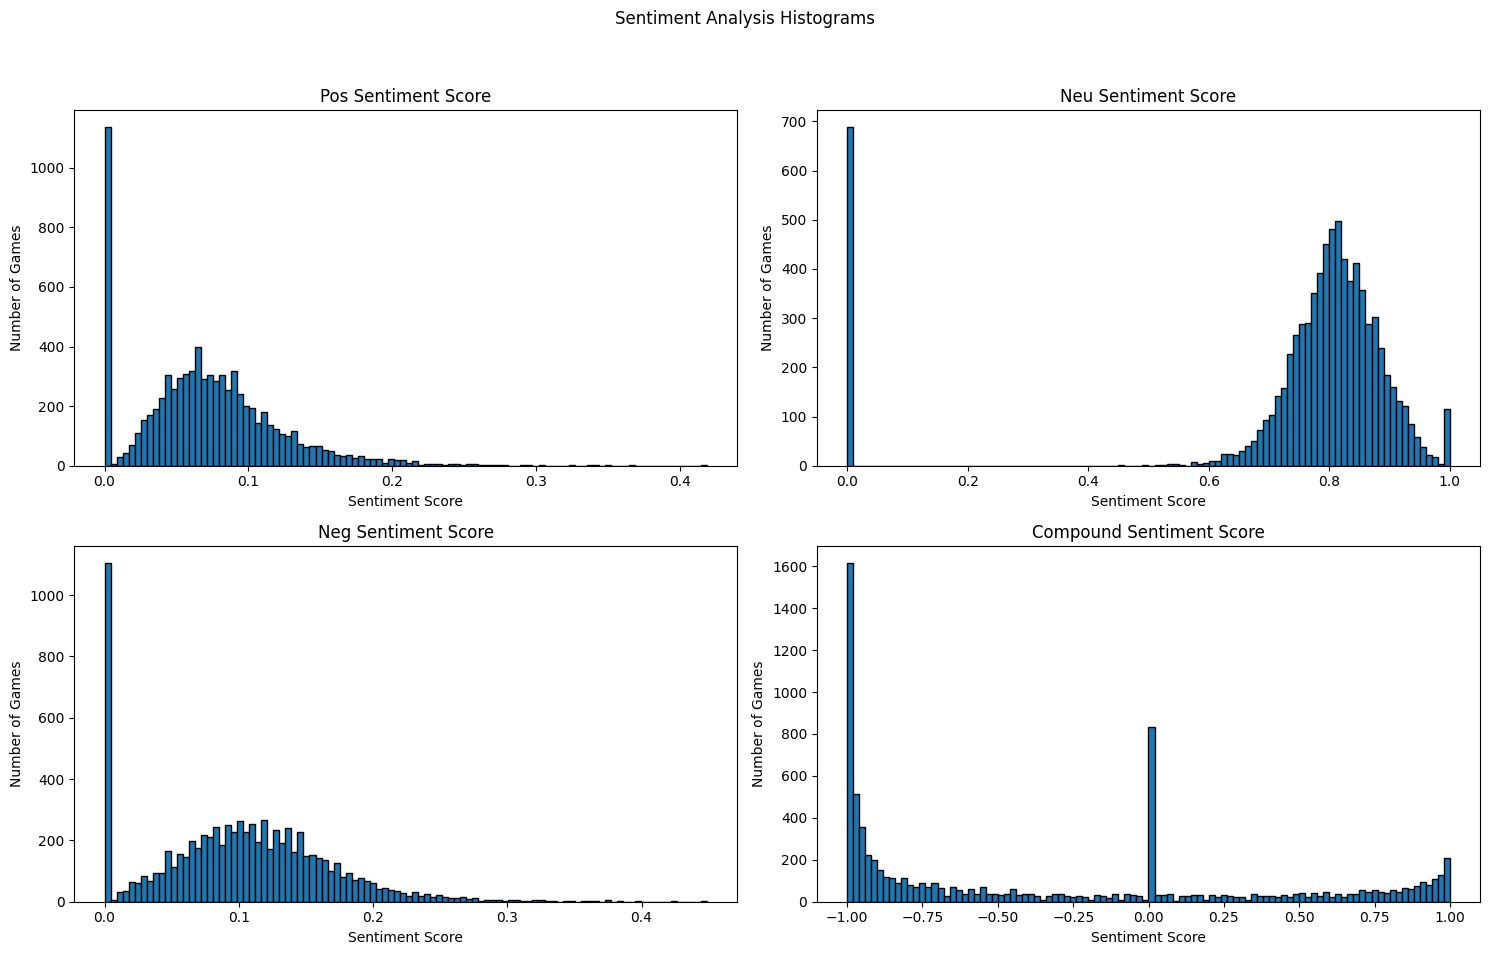

In [15]:
create_sentiment_histograms(sentiment_scores["plot"])

In [30]:

# Example usage
# Assuming sentiment_scores_plot is already calculated
print_top_bottom_sentiment_games(sentiment_scores["plot"])


10 Most Negative Games in terms of compound sentiment:
Sub Rebellion: -0.9999
Devil May Cry 3: Dante's Awakening: -0.9999
Raw Danger!: -0.9998
Ace Attorney Investigations 2: -0.9998
Ninja Gaiden II: The Dark Sword of Chaos: -0.9997
Forbidden Siren 2: -0.9997
Kane & Lynch: Dead Men: -0.9997
Syphon Filter: Logan's Shadow: -0.9997
Muramasa: The Demon Blade: -0.9997
Skylanders: Trap Team: -0.9997


10 Most Positive Games in terms of compound sentiment:
The Legend of Heroes: A Tear of Vermillion: 0.9984
Endless Ocean 2: Adventures of the Deep: 0.9986
Dragon Quest Monsters: Joker 2: 0.9986
Shin Megami Tensei (video game): 0.9987
Dragon Quest V: 0.9989
Dragon Quest Monsters: Joker: 0.9989
Shin Megami Tensei III: Nocturne: 0.999
Fossil Fighters (video game): 0.9991
Dragon Ball Xenoverse 2: 0.9991
Megadimension Neptunia VII: 0.9995


In [31]:
sentiment_scores["gameplay"]["Tetris"], sentiment_scores["gameplay"]["God of War (2005 video game)"], sentiment_scores["gameplay"]["Minecraft"]

({'neg': 0.044, 'neu': 0.847, 'pos': 0.109, 'compound': 0.9531},
 {'neg': 0.141, 'neu': 0.811, 'pos': 0.049, 'compound': -0.9797},
 {'neg': 0.103, 'neu': 0.84, 'pos': 0.057, 'compound': -0.9898})

In [34]:
sorted(sentiment_scores["plot"].items(), key=lambda x: -x[1]["neg"])

[('Cuthbert in the Mines',
  {'neg': 0.449, 'neu': 0.551, 'pos': 0.0, 'compound': -0.9081}),
 ('GunForce', {'neg': 0.424, 'neu': 0.576, 'pos': 0.0, 'compound': -0.91}),
 ('Beyond the Ice Palace',
  {'neg': 0.399, 'neu': 0.53, 'pos': 0.071, 'compound': -0.9796}),
 ('Aero Fighters 3',
  {'neg': 0.383, 'neu': 0.497, 'pos': 0.12, 'compound': -0.967}),
 ('Zen: Intergalactic Ninja (video game)',
  {'neg': 0.375, 'neu': 0.53, 'pos': 0.095, 'compound': -0.8126}),
 ('Specnaz: Project Wolf',
  {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.8807}),
 ('Deep Black (video game)',
  {'neg': 0.375, 'neu': 0.513, 'pos': 0.112, 'compound': -0.9062}),
 ('Doom 3: BFG Edition',
  {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.6597}),
 ('Mister Slime',
  {'neg': 0.367, 'neu': 0.512, 'pos': 0.121, 'compound': -0.743}),
 ('Island Peril', {'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compound': -0.926}),
 ('Abuse (video game)',
  {'neg': 0.358, 'neu': 0.603, 'pos': 0.04, 'compound': -0.9909}),
 ('G

In [59]:
from transformers import pipeline

# Load the sentiment-analysis pipeline
nlp = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

sentiment_scores["gameplay"]["God of War (2005 video game)"], sentiment_scores["gameplay"]["Minecraft"]
# Perform sentiment analysis
prompt = "Rate the violent of the game base on the gameplay: "
(nlp(prompt+game_data["Tetris"]["text"]["gameplay"][:502]),sentiment_scores["gameplay"]["Tetris"]), nlp(prompt+game_data["God of War (2005 video game)"]["text"]["gameplay"][:502]),  nlp(prompt+game_data["Minecraft"]["text"]["gameplay"][:502])



(([[{'label': 'positive', 'score': 0.18072612583637238},
    {'label': 'neutral', 'score': 0.11749538034200668},
    {'label': 'negative', 'score': 0.7017784714698792}]],
  {'neg': 0.044, 'neu': 0.847, 'pos': 0.109, 'compound': 0.9531}),
 [[{'label': 'positive', 'score': 0.23579217493534088},
   {'label': 'neutral', 'score': 0.04997564107179642},
   {'label': 'negative', 'score': 0.7142321467399597}]],
 [[{'label': 'positive', 'score': 0.22284410893917084},
   {'label': 'neutral', 'score': 0.148197740316391},
   {'label': 'negative', 'score': 0.6289582252502441}]])